# Comparing Popularity of Venues in New York City Neighborhoods Affected by COVID-19

## Introduction: Business Problem

New York city has been one of the most impacted cities in the United States by COVID-19. In the last six months, there have been over 220,000 confirmed cases in the city itself. Currently, the city is reopening. With the reopening of the city, the population may have different needs or wants in terms of available businesses. Prospective business owners are curious as to which venues are most popular in each borough and if there is a relation between the number of COVID cases and the type of popular venues.

## Data

The data necessary to solve this problem includes New York neighborhood data, New York COVID-19 data, and Foursquare location data. 

First, we will need data to determine the prevalence of the virus in each neighborhood. We need a dataset containing the number of covid cases by the neighborhood. This data is available here: https://github.com/nychealth/coronavirus-data/blob/master/data-by-modzcta.csv.

Additionally, we will need to determine the latitude and longitude values in each ZCTA to create maps and use Foursquare. This information is available from the census bureau here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=ZIP+Code+Tabulation+Areas

Finally, we will use the Foursquare location data to determine which nearby venues are most popular in the different neighborhoods.

## Methodology

### First, we will import the necessary dependencies.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import io

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Load NYC Health Data into Dataframe

In [2]:
url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv"
df = pd.read_csv(url)
df.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,431,1829.14,23563.03,26,110.34,6.51,6624
1,10002,Chinatown/Lower East Side,Manhattan,1278,1665.03,76755.41,161,209.76,9.35,13668
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,519,964.65,53801.62,34,63.20,4.85,10700
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,5.42,719
4,10005,Financial District,Manhattan,87,1036.19,8396.11,2,23.82,5.08,1713


### Modify Dataframe to Include Necessary Data Only

In [3]:
neighborhoods = df[['BOROUGH_GROUP', 'NEIGHBORHOOD_NAME', 'MODIFIED_ZCTA', 'COVID_CASE_COUNT', 'COVID_CASE_RATE', 'COVID_DEATH_COUNT']].copy()
neighborhoods.columns = ['Borough', 'Neighborhood', 'ZCTA', 'Covid Case Count', 'Covid Case Rate', 'Covid Death Count']
neighborhoods.head()

,Borough,Neighborhood,ZCTA,Covid Case Count,Covid Case Rate,Covid Death Count
0,Manhattan,Chelsea/NoMad/West Chelsea,10001,431,1829.14,26
1,Manhattan,Chinatown/Lower East Side,10002,1278,1665.03,161
2,Manhattan,East Village/Gramercy/Greenwich Village,10003,519,964.65,34
3,Manhattan,Financial District,10004,39,1068.32,1
4,Manhattan,Financial District,10005,87,1036.19,2


### Use Census Data to Obtain Latitude and Longitude Values

In [4]:
#load data into a dataframe
url = "https://raw.githubusercontent.com/taylorflowers/Applied-Data-Science-Capstone/master/zcta.csv"
df2 = pd.read_csv(url)
df2.head()

,"ZCTA5CE10,C,5","GEOID10,C,5","CLASSFP10,C,2","MTFCC10,C,5","FUNCSTAT10,C,1","ALAND10,N,14,0","AWATER10,N,14,0","INTPTLAT10,C,11","INTPTLON10,C,12"
0,43451,43451,B5,G6350,S,63411475,157689,41.318301,-83.617494
1,43452,43452,B5,G6350,S,121783676,13437380,41.515792,-82.980945
2,43456,43456,B5,G6350,S,9389362,999166,41.646845,-82.822664
3,43457,43457,B5,G6350,S,48035540,0,41.267327,-83.427464
4,43458,43458,B5,G6350,S,2573816,39915,41.530446,-83.213365


In [5]:
#access relevant columns and rename
zcta = df2[['ZCTA5CE10,C,5', 'INTPTLAT10,C,11', 'INTPTLON10,C,12']].copy()
zcta.columns = ['ZCTA', 'Latitude', 'Longitude']
zcta.head()

,ZCTA,Latitude,Longitude
0,43451,41.318301,-83.617494
1,43452,41.515792,-82.980945
2,43456,41.646845,-82.822664
3,43457,41.267327,-83.427464
4,43458,41.530446,-83.213365


### Merge Data by ZCTA

In [6]:
ny_data = pd.merge(neighborhoods, zcta, on='ZCTA')
ny_data.head()

,Borough,Neighborhood,ZCTA,Covid Case Count,Covid Case Rate,Covid Death Count,Latitude,Longitude
0,Manhattan,Chelsea/NoMad/West Chelsea,10001,431,1829.14,26,40.750634,-73.997176
1,Manhattan,Chinatown/Lower East Side,10002,1278,1665.03,161,40.715777,-73.986207
2,Manhattan,East Village/Gramercy/Greenwich Village,10003,519,964.65,34,40.731829,-73.989181
3,Manhattan,Financial District,10004,39,1068.32,1,40.688873,-74.018213
4,Manhattan,Financial District,10005,87,1036.19,2,40.706004,-74.008785


### Run k-means to cluster the neighborhoods into 5 clusters based on Covid severity.

In [7]:
#create smaller dataframe
ny_covid_grouped = ny_data[['Neighborhood','Covid Case Count','Covid Case Rate', 'Covid Death Count']].copy()

# set number of clusters
covid_kclusters = 5

ny_covid_clustering = ny_covid_grouped.drop('Neighborhood', 1)

# run k-means clustering
covid_kmeans = KMeans(n_clusters=covid_kclusters, random_state=0).fit(ny_covid_clustering)

# check cluster labels generated for each row in the dataframe
covid_kmeans.labels_[0:10]

array([1, 1, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

### Now add cluster values to NY Dataframe.

In [8]:
# add clustering labels
ny_data.insert(3, 'Covid Cluster Labels', covid_kmeans.labels_)
ny_data.head()

,Borough,Neighborhood,ZCTA,Covid Cluster Labels,Covid Case Count,Covid Case Rate,Covid Death Count,Latitude,Longitude
0,Manhattan,Chelsea/NoMad/West Chelsea,10001,1,431,1829.14,26,40.750634,-73.997176
1,Manhattan,Chinatown/Lower East Side,10002,1,1278,1665.03,161,40.715777,-73.986207
2,Manhattan,East Village/Gramercy/Greenwich Village,10003,3,519,964.65,34,40.731829,-73.989181
3,Manhattan,Financial District,10004,3,39,1068.32,1,40.688873,-74.018213
4,Manhattan,Financial District,10005,3,87,1036.19,2,40.706004,-74.008785


In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(covid_kclusters)
ys = [i + x + (i*x)**2 for i in range(covid_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood'], ny_data['Covid Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Give more descriptive cluster labels.

In [11]:
ny_data.loc[ny_data['Covid Cluster Labels'] == 0, ny_data.columns[[3]]] = '2nd Most Severe'

In [12]:
ny_data.loc[ny_data['Covid Cluster Labels'] == 1, ny_data.columns[[3]]] = '4th Most Severe'

In [13]:
ny_data.loc[ny_data['Covid Cluster Labels'] == 2, ny_data.columns[[3]]] = 'Least Severe'

In [14]:
ny_data.loc[ny_data['Covid Cluster Labels'] == 3, ny_data.columns[[3]]] = '3rd Most Severe'

In [15]:
ny_data.loc[ny_data['Covid Cluster Labels'] == 4, ny_data.columns[[3]]] = 'Most Severe'

### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'OWT2CBAVV1ANFU23R0MLS0JBCR4OGIH1WRPRAEQ13UBT5HYN' # Foursquare ID
CLIENT_SECRET = 'NSESC3OEAJVKLY1JSITS02OLO5S02XTAWEZYW5SU5GMI2OW4' # Foursquare Secret
VERSION = '20180604'

### Create a function to get nearby venues for each neighborhood.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
ny_venues = getNearbyVenues(names= ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )
ny_venues.shape

(7424, 7)

### Analyze Each Neighborhood

In [19]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#ny_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
ny_onehot.insert(loc=0, column='Neighborhood', value=ny_venues['Neighborhood'] )

ny_onehot.shape

(7424, 406)

### Group rows by neighborhood. For each venue category, take the mean of the frequency of occurrence.¶

In [20]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Terminal,Airport Tram,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Industrial Estate,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts 

### Create a function to get most common venues in a neighborhood.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airport/East Elmhurst,Supermarket,Ice Cream Shop,Gas Station,Gourmet Shop,Mexican Restaurant,Pharmacy,Dry Cleaner,Donut Shop,Video Store,Chinese Restaurant
1,Airport/South Jamaica/Springfield Gardens/St. ...,Pharmacy,Fast Food Restaurant,Bank,Health & Beauty Service,Chinese Restaurant,Caribbean Restaurant,Candy Store,Fried Chicken Joint,Deli / Bodega,Food Court
2,Allerton/Baychester/Pelham Gardens/Williamsbridge,Caribbean Restaurant,Dance Studio,Donut Shop,Spa,Metro Station,Bank,Pharmacy,Liquor Store,Pizza Place,Fried Chicken Joint
3,Allerton/Norwood/Pelham Parkway/Williamsbridge,Caribbean Restaurant,Mexican Restaurant,Supermarket,Storage Facility,Pizza Place,Bakery,Donut Shop,Metro Station,Spa,Discount Store
4,Alphabet City/East Village/Stuyvesant Town-Coo...,Cocktail Bar,Bar,Coffee Shop,Mexican Restaurant,Italian Restaurant,Wine Bar,Pizza Place,Korean Restaurant,Garden,Ice Cream Shop


### Run k-means to cluster the neighborhoods into 10 clusters.

In [23]:
# set number of clusters
venue_kclusters = 10

ny_venue_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
venue_kmeans = KMeans(n_clusters=venue_kclusters, random_state=0).fit(ny_venue_clustering)

# check cluster labels generated for each row in the dataframe
venue_kmeans.labels_[0:10]

array([5, 5, 5, 5, 8, 8, 9, 5, 9, 1], dtype=int32)

### Now create a new dataframe that includes the cluster and the top 10 venues for each neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Venue Cluster Labels', venue_kmeans.labels_)

# add latitude/longitude and covid data for each neighborhood
ny_data = ny_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_data.head()

,Borough,Neighborhood,ZCTA,Covid Cluster Labels,Covid Case Count,Covid Case Rate,Covid Death Count,Latitude,Longitude,Venue Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Chelsea/NoMad/West Chelsea,10001,4th Most Severe,431,1829.14,26,40.750634,-73.997176,8,Dance Studio,Burger Joint,Hotel,Coffee Shop,Salad Place,Music Venue,Indie Theater,Pizza Place,Park,Grocery Store
1,Manhattan,Chinatown/Lower East Side,10002,4th Most Severe,1278,1665.03,161,40.715777,-73.986207,8,Mexican Restaurant,Cocktail Bar,Coffee Shop,Chinese Restaurant,American Restaurant,Café,Bar,Bakery,Sandwich Place,Ice Cream Shop
2,Manhattan,East Village/Gramercy/Greenwich Village,10003,3rd Most Severe,519,964.65,34,40.731829,-73.989181,8,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Mediterranean Restaurant,Coffee Shop,Indie Theater,Grocery Store,Bar,Gourmet Shop,Pizza Place
3,Manhattan,Financial District,10004,3rd Most Severe,39,1068.32,1,40.688873,-74.018213,8,Coffee Shop,Pizza Place,Food Truck,Hotel,Gym / Fitness Center,Café,Park,American Restaurant,Falafel Restaurant,Gym
4,Manhattan,Financial District,10005,3rd Most Severe,87,1036.19,2,40.706004,-74.008785,8,Coffee Shop,Pizza Place,Food Truck,Hotel,Gym / Fitness Center,Café,Park,American Restaurant,Falafel Restaurant,Gym


In [25]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(venue_kclusters)
ys = [i + x + (i*x)**2 for i in range(venue_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood'], ny_data['Venue Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Text(0.5, 1.0, 'Most Severe Covid Neighborhood Venue Popularity')

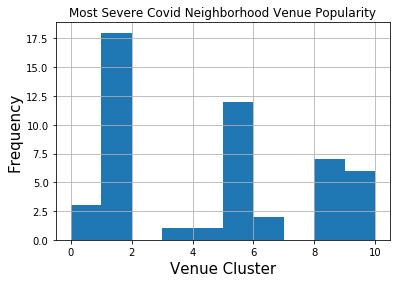

In [27]:
df = ny_data[['Covid Cluster Labels','Venue Cluster Labels']]
df = df.loc[df['Covid Cluster Labels']=='Most Severe',['Venue Cluster Labels']]
hist = df.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Venue Cluster", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Most Severe Covid Neighborhood Venue Popularity")

Text(0.5, 1.0, '2nd Most Severe Covid Neighborhood Venue Popularity')

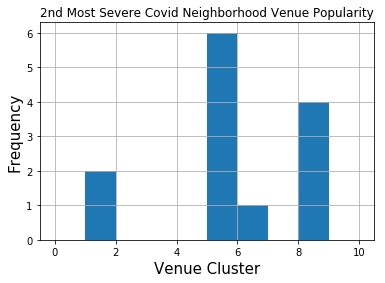

In [28]:
df = ny_data[['Covid Cluster Labels','Venue Cluster Labels']]
df = df.loc[df['Covid Cluster Labels']=='2nd Most Severe',['Venue Cluster Labels']]
hist = df.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Venue Cluster", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("2nd Most Severe Covid Neighborhood Venue Popularity")

Text(0.5, 1.0, '3rd Most Severe Covid Neighborhood Venue Popularity')

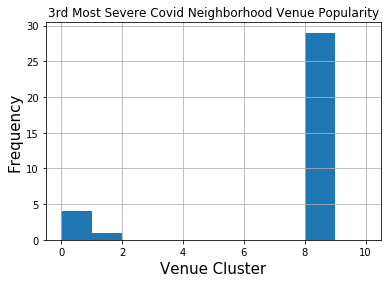

In [29]:
df = ny_data[['Covid Cluster Labels','Venue Cluster Labels']]
df = df.loc[df['Covid Cluster Labels']=='3rd Most Severe',['Venue Cluster Labels']]
hist = df.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Venue Cluster", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("3rd Most Severe Covid Neighborhood Venue Popularity")

Text(0.5, 1.0, '4th Most Severe Covid Neighborhood Venue Popularity')

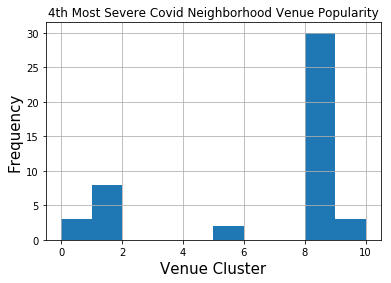

In [30]:
df = ny_data[['Covid Cluster Labels','Venue Cluster Labels']]
df = df.loc[df['Covid Cluster Labels']=='4th Most Severe',['Venue Cluster Labels']]
hist = df.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Venue Cluster", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("4th Most Severe Covid Neighborhood Venue Popularity")

Text(0.5, 1.0, 'Least Severe Covid Neighborhood Venue Popularity')

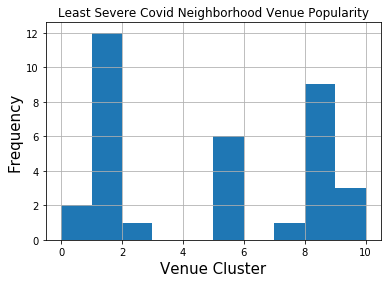

In [31]:
df = ny_data[['Covid Cluster Labels','Venue Cluster Labels']]
df = df.loc[df['Covid Cluster Labels']=='Least Severe',['Venue Cluster Labels']]
hist = df.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Venue Cluster", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Least Severe Covid Neighborhood Venue Popularity")